### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions
using MDToolbox

### ポテンシャルエネルギー関数の定義

In [2]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [4]:
#二原子のトラジェクトリからFを計算
function compute_free_energy(coords1_trj, coords2_trj, beta, epsilon, sigma)
    N = size(coords1_trj, 1)
    U_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in zip(coords1_trj, coords2_trj)]
    #F = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* U_array)))
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array))
    return F
end

compute_free_energy (generic function with 1 method)

In [5]:
# exponential averaging
function compute_deltaF(coords_trj , beta, epsilon, sigma, U_array)
    N = size(coords_trj, 1)
    U_target_array = [compute_energy(coords1, coords2, epsilon, sigma) for (coords1, coords2) in coords_trj]
    deltaU = U_target_array .- U_array
    #@show deltaU
    #deltaF = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* deltaU)))
    deltaF = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* deltaU))
    return deltaF
end

compute_deltaF (generic function with 1 method)

### MCMCの定義

In [6]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-1)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

next_coords (generic function with 2 methods)

In [7]:
#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        next_U = compute_energy(next_coords1, next_coords2, epsilon, sigma)
        current_U = compute_energy(coords1, coords2, epsilon, sigma)
        delta_U = next_U - current_U
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    return coords1_trj, coords2_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### ΔFを求める

In [8]:
kBT = 0.1
beta = 1.0/(kBT)
nstep = 1000000

K = 2

epsilon = Vector{Float64}(undef, K)
sigma = Vector{Float64}(undef, K)

epsilon[1] = 1.0
sigma[1] = 4.0

epsilon[2] = 1.2
sigma[2] = 4.2

trj1 = Vector{Any}(undef, K)
trj2 = Vector{Any}(undef, K)
for k = 1:K
    trj1[k], trj2[k], alpha = mcmc(rand(3), rand(3), epsilon[k], sigma[k], nstep, beta)
end

In [9]:
u_kl = Array{Any}(undef, (K, K))

for k = 1:K
    for l = 1:K
        u_kl[k, l] = map(x -> beta * compute_energy(x[1], x[2], epsilon[l], sigma[l]), zip(trj1[k], trj2[k]))
    end
end

In [10]:
f_k = mbar(u_kl)
(1 ./ beta) .* f_k

iteration = 1  delta = 1.414214e+00  tol = 1.000000e-08
free energies =  0.000000 -1.341288

iteration = 2  delta = 3.836681e-01  tol = 1.000000e-08
free energies =  0.000000 -1.840644

iteration = 3  delta = 1.067549e-01  tol = 1.000000e-08
free energies =  0.000000 -1.990934

iteration = 4  delta = 2.838215e-02  tol = 1.000000e-08
free energies =  0.000000 -2.031709

iteration = 5  delta = 7.404166e-03  tol = 1.000000e-08
free energies =  0.000000 -2.042402

iteration = 6  delta = 1.920881e-03  tol = 1.000000e-08
free energies =  0.000000 -2.045180

iteration = 7  delta = 4.976016e-04  tol = 1.000000e-08
free energies =  0.000000 -2.045900

iteration = 8  delta = 1.288531e-04  tol = 1.000000e-08
free energies =  0.000000 -2.046086

iteration = 9  delta = 3.336297e-05  tol = 1.000000e-08
free energies =  0.000000 -2.046134

iteration = 10  delta = 8.638196e-06  tol = 1.000000e-08
free energies =  0.000000 -2.046147

iteration =11  delta = 3.017939e-07  tol = 1.000000e-08
free energies

2-element Vector{Float64}:
  0.0
 -0.20461512088175762

In [11]:
# Sanity check
F = Vector{Any}(undef, K)
for k = 1:K
    F[k] = compute_free_energy(trj1[k], trj2[k], beta, epsilon[k], sigma[k])
end
@show F .- F[1]

F .- F[1] = [0.0, -0.20242675563070878]


2-element Vector{Float64}:
  0.0
 -0.20242675563070878

In [12]:
epsilon_target = 1.1
sigma_target = 4.1

trj1_target, trj2_target, alpha = mcmc(rand(3), rand(3), epsilon_target, sigma_target, nstep, beta);

In [13]:
@show F_target = compute_free_energy(trj1_target, trj2_target, beta, epsilon_target, sigma_target)

@show delta_F = F_target - F[1]

F_target = compute_free_energy(trj1_target, trj2_target, beta, epsilon_target, sigma_target) = -1.0594618799669533
delta_F = F_target - F[1] = -0.10164872191252805


-0.10164872191252805

In [14]:
# Sanity check
u_k = Vector{Any}(undef, K)

for k = 1:K
    u_k[k] = map(x -> beta * compute_energy(x[1], x[2], epsilon_target, sigma_target), zip(trj1[k], trj2[k]))
end

f_target = mbar_f(u_kl, f_k, u_k)
@show f_target
(1 ./ beta) * (f_target - f_k[1])

f_target = -1.0221555927525596


-0.10221555927525597

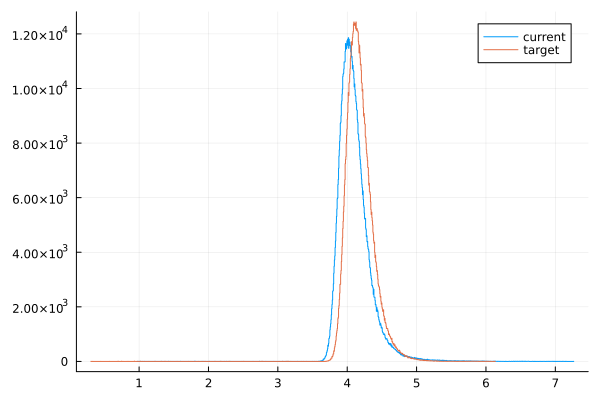

In [15]:
k = 1
r = [sqrt(sum((x - y).^2)) for (x, y) in zip(trj1[k], trj2[k])]
histogram(r,label="current")
r = [sqrt(sum((x - y).^2)) for (x, y) in zip(trj1_target, trj2_target)]
histogram!(r,label="target")

In [16]:
#パラメータ推定に用いる原子の軌跡と自由エネルギーの差
X_train = []
for k = 1:K
    push!(X_train, (trj1[k], trj2[k]))
end
y_train = delta_F

-0.10164872191252805

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [17]:
function compute_deltaF(X, f_k, u_kl, beta, epsilon, sigma)
    #K = length(f_k)
    #u_k = Vector{Vector{Float64}}(undef, 0)
    #for k = 1:K
        #for istep = 1:nstep
        #    u_k[k][istep] = beta * compute_energy(X[1][k][istep], X[2][k][istep], m.P[1], m.P[2])
        #end
        #push!(u_k, map(x -> beta * compute_energy(x[1], x[2], epsilon, sigma), zip(X[1][k], X[2][k])))
    #end
    u_k = map(XX -> map(x -> beta * compute_energy(x[1], x[2], epsilon, sigma), zip(XX[1], XX[2])), X)
    f_target = mbar_f(u_kl, f_k, u_k)
    delta_F = (1 ./ beta) * (f_target - f_k[1])
    return delta_F
end

compute_deltaF (generic function with 2 methods)

In [18]:
struct MBAR
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor MBAR (P,)

(m::MBAR)(X) = compute_deltaF(X, f_k, u_kl, beta, m.P[1], m.P[2])


In [27]:
# Sanity check
m = MBAR([epsilon_target, sigma_target])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

3.2130459578434096e-7

In [32]:
m = MBAR([epsilon[2], sigma[2]])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

0.010602079316690572

In [33]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader(X_train, batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-3)

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [34]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [36]:
loss_train = []

for epoch in 1:100
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    L = loss(X_train, y_train)
    push!(loss_train, L)
    print_callback(epoch, L, ps)
end

Epoch: 1, loss: 0.008408322338327433
param: [1.1890007484727265, 4.188998585879782]
Epoch: 2, loss: 0.00822156908466321
param: [1.1880012015129742, 4.187998400584573]
Epoch: 3, loss: 0.008036944879418964
param: [1.1870018201381844, 4.186998267921584]
Epoch: 4, loss: 0.007854454831279169
param: [1.186002639370107, 4.1859982140362915]
Epoch: 5, loss: 0.007674104375964935
param: [1.1850036976394804, 4.1849982685899665]
Epoch: 6, loss: 0.007495899242985766
param: [1.1840050367985626, 4.183998464786849]
Epoch: 7, loss: 0.007319845421305434
param: [1.1830067021281516, 4.182998839394967]
Epoch: 8, loss: 0.007145949124101337
param: [1.182008742339597, 4.181999432761086]
Epoch: 9, loss: 0.006974216752791959
param: [1.1810112095723293, 4.1810002888202895]
Epoch: 10, loss: 0.006804654860501848
param: [1.180014159387439, 4.180001455100741]
Epoch: 11, loss: 0.006637270115124328
param: [1.1790176507578416, 4.17900298272416]
Epoch: 12, loss: 0.0064720692621343025
param: [1.1780217460555562, 4.1780049

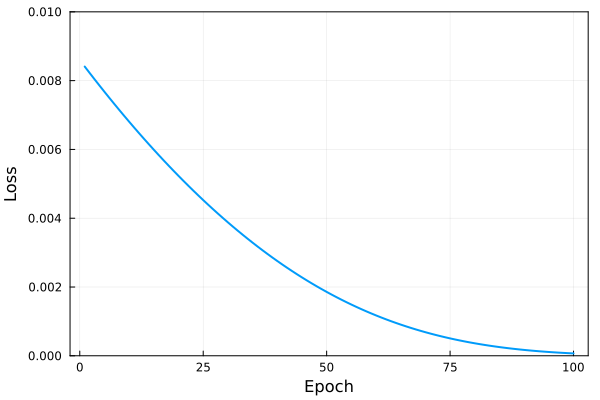

In [37]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2, ylims=(0.0, 0.01))
ylabel!("Loss")
xlabel!("Epoch")

In [38]:
println("Initial epsilon:   ", epsilon[2])
println("Estimated epsilon: ", m.P[1])
println("Target epsilon:    ", epsilon_target)
println()
println("Initial sigma:   ", sigma[2])
println("Estimated sigma: ", m.P[2])
println("Target sigma:    ", sigma_target)

Initial epsilon:   1.2
Estimated epsilon: 1.1076383388653959
Target epsilon:    1.1

Initial sigma:   4.2
Estimated sigma: 4.106540177830336
Target sigma:    4.1
